In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
USE_CUDA = torch.cuda.is_available() 
device = torch.device("cuda" if USE_CUDA else "cpu") 
print("device", device)

device cpu


In [2]:
class bnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 10
        self.tanh = nn.Tanh()
        
        self.w1 = nn.Parameter(
            torch.zeros(2, self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32,requires_grad=True)
        )
        self.w2 = nn.Parameter(
            torch.zeros(self.hidden_size, 1, dtype = torch.float32, requires_grad=True)
        )
        
        
    def rep(self, mu):
        return mu + torch.randn_like(mu)*0.1

    def forward(self, x, batch_size):
        b = self.rep(self.b)
        w1 = self.rep(self.w1)
        w2 = self.rep(self.w2)
        b = b.expand(batch_size, self.hidden_size)
        x = torch.matmul(x, w1) + b
        x = self.tanh(x)
        x = torch.matmul(x, w2)
        return x, self.w1, self.w2, self.b
    
    def kldloss(self, w1, w2, b):
        sum1 = torch.sum(torch.square(self.w1 - w1))
        sum2 = torch.sum(torch.square(self.w2 - w2))
        sum3 = torch.sum(torch.square(self.b - b))
        return sum1 + sum2 + sum3
    
mybnn = bnn()



In [3]:
tmp_data = torch.tensor([[-1., 3., 5], [-2, 2, 5], [-0.5, 2, 4], 
                         [-0.5, 1.5, 3], [0.5, 1, 1], [1, 1, -1],
                         [2, 2, -3], [3, 2, -4], [4, 4, -5],
                         [5, 4, -4], [5, 5, -3], [6, 4, -2],
                         [7, 4, -1], [8, 3, 0], [8, 4, 1],
                         [9, 3, 3], [9, 1, 5], [10, 2, 6]])
batch_size = 18
hidden_size = 10

w1 = torch.zeros(2, hidden_size)
b = torch.zeros(hidden_size)
w2 = torch.zeros(hidden_size, 1)
#we have to save posterior to prior w1, w2, b

In [4]:
train_dataloader = DataLoader(tmp_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(mybnn.parameters(), lr=0.001)



In [5]:
i = 0
while i < 1000:
    train_data = next(iter(train_dataloader))
    newdata = torch.split(train_data, 2, dim = 1)
    output = mybnn(newdata[0],batch_size)
    likelihood = torch.sum(torch.square(newdata[1] - output[0]))
    w1 = output[1]
    w2 = output[2]
    b = output[3]
    loss = likelihood + mybnn.kldloss(w1,w2,b)*100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(loss)
    i = i + 1

In [7]:
#mybnn.w1

In [8]:
#mybnn.b

In [9]:
#mybnn.w2

In [10]:
import matplotlib.pyplot as plt
import numpy as np

/var/folders/st/r65dx1gj24dfq3hzdk46g_8c0000gn/T/ipykernel_85375/1739489043.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z9 = torch.tensor(z, requires_grad = False).numpy()
No handles with labels found to put in legend.


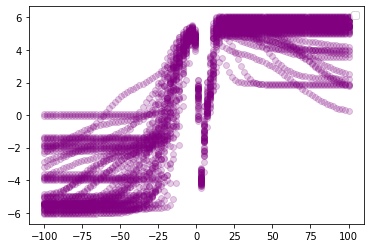

In [20]:
x = np.linspace(-100, 100, 100)
y = np.linspace(3, 3, 100)
newxy = np.concatenate((np.transpose([x]), np.transpose([y])), axis = 1)
newxy = torch.tensor(newxy, dtype = torch.float32)
newxy = torch.reshape(newxy,(100,2))


i = 0
while i<50:
    z = mybnn(newxy,100)[0]
    Z9 = torch.tensor(z, requires_grad = False).numpy()
    plt.scatter(x, Z9, color = 'purple', alpha = 0.2)
    i = i + 1

plt.legend()
plt.show()

In [21]:

'''
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-8, 10, 10)
X = np.tile(x, (10, 1))
Y = np.transpose(X)
Z = np.random.rand(10, 10)


x_m = np.reshape(X, (10,10,1))
y_m = np.reshape(Y, (10,10,1))

newxy = np.concatenate((x_m, y_m), axis = 2)

newxy = torch.tensor(newxy, dtype = torch.float32)

newxy = torch.reshape(newxy,(100,2))

z = mybnn(newxy,100)[0]
Z = torch.tensor(z, requires_grad = False).numpy()
Z = np.reshape(Z,(10,10))


ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)

plt.tight_layout()
plt.show()
'''

"\nfrom mpl_toolkits.mplot3d import axes3d\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\nx = np.linspace(-8, 10, 10)\nX = np.tile(x, (10, 1))\nY = np.transpose(X)\nZ = np.random.rand(10, 10)\n\n\nx_m = np.reshape(X, (10,10,1))\ny_m = np.reshape(Y, (10,10,1))\n\nnewxy = np.concatenate((x_m, y_m), axis = 2)\n\nnewxy = torch.tensor(newxy, dtype = torch.float32)\n\nnewxy = torch.reshape(newxy,(100,2))\n\nz = mybnn(newxy,100)[0]\nZ = torch.tensor(z, requires_grad = False).numpy()\nZ = np.reshape(Z,(10,10))\n\n\nax.plot_surface(X, Y, Z)\nax.set_zlim(-10, 10)\n\nplt.tight_layout()\nplt.show()\n"